In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import re
import os
from datetime import datetime, timedelta
os.getcwd()
df = pd.DataFrame()

In [2]:
df = pd.read_csv('./dws_dsc_activity_hourly_detail_di.csv', nrows = 15555)
re1 = re.compile(r'(?<=\.).+')
df.columns = [re1.findall(i)[0] for i in list(df.columns.to_numpy())]
df = df.dropna(subset=['activity_start_time'])


In [3]:
df['activity_end_time'] = pd.to_datetime(df['activity_end_time'])
df['activity_start_time'] = pd.to_datetime(df['activity_start_time'].fillna(0))
df['create_time'] = pd.to_datetime(df['create_time'])

In [4]:
"""
d单个activity的耗费时间.
"""
df['time_gap_inner'] = df['activity_end_time']-df['activity_start_time']
df['time_gap_inner'] = df['time_gap_inner'].fillna(
    timedelta(0)
    ).apply(timedelta.total_seconds)
df['time_gap_inner'] = [0 if i < 0 else i for i in df['time_gap_inner']]

"""
前一个activity到后一个activity相差的时间\. (单个时间内会有大量activity发生.)
"""
df = df.sort_values('activity_start_time')
df['time_gap_outer'] = df\
    .groupby(['user_id','inc_day'], dropna = False)['activity_start_time'].transform('diff')
df['time_gap_outer'] = df['time_gap_outer'].fillna(timedelta(0)).apply(timedelta.total_seconds)
df['time_gap_outer'] = [0 if i< 0 else i for i in df['time_gap_outer']]

"""
time gap of the day. 总计活跃时间, ( 未减除动作间的时间间隔 )
"""
mid1 = df.groupby(['inc_day', 'user_id']).agg(
    a = ('activity_start_time','min'), 
    b  = ('activity_start_time', 'max'))\
        [['a','b']].diff(axis = 1)['b'].apply(timedelta.total_seconds).reset_index()
mid1.columns = ['inc_day','user_id','time_gap_today']
df = df.merge(mid1, on = ['inc_day', 'user_id'], how = 'left')


In [5]:
def get_hour():
    list = ['activity_start_time', 'activity_end_time','create_time']
    
    for i in list: 
        listnew = i + '_hour'
        df[listnew] = df[i].dt.round('min').astype(str).str.slice(11,)
    return df
df = get_hour() 

In [156]:
pd.set_option("display.max_rows", None, "display.max_columns", 55)
df[df['user_id'] == 'BJMARS003'].query('time_gap_outer != 0')[[
    'activity_start_time', 'activity_end_time','time_gap_inner'	,'time_gap_outer','time_gap_today']].\
        sort_values('activity_start_time', ascending=False)

,activity_start_time,activity_end_time,time_gap_inner,time_gap_outer,time_gap_today
15339,2021-09-26 08:21:24,2021-09-26 08:21:29,5.0,7.0,12913.0
15336,2021-09-26 08:21:17,2021-09-26 08:21:20,3.0,5.0,12913.0
15328,2021-09-26 08:21:12,2021-09-26 08:21:15,3.0,64.0,12913.0
15228,2021-09-26 08:20:08,2021-09-26 08:21:10,62.0,215.0,12913.0
14921,2021-09-26 08:16:33,2021-09-26 08:18:01,88.0,119.0,12913.0
14727,2021-09-26 08:14:34,2021-09-26 08:15:30,56.0,83.0,12913.0
14593,2021-09-26 08:13:11,2021-09-26 08:14:19,68.0,90.0,12913.0
14470,2021-09-26 08:11:41,2021-09-26 08:11:48,7.0,116.0,12913.0
14272,2021-09-26 08:09:45,2021-09-26 08:09:49,4.0,89.0,12913.0
14148,2021-09-26 08:08:16,2021-09-26 08:08:21,5.0,148.0,12913.0


In [27]:
df[['ou_code', 'ou_name', 'wms_warehouse_id', 'user_id', 'activity_type' ,
       'activity_start_time', 'activity_end_time',   
       'activity_id',  'lpn','sku_code', 'qty',
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']]\
              .query("user_id == 'DGMHE' & activity_start_time == '2021-09-26 00:00:35' ")

,ou_code,ou_name,wms_warehouse_id,user_id,activity_type,activity_start_time,activity_end_time,activity_id,lpn,sku_code,qty,time_gap_inner,time_gap_outer,time_gap_today,activity_start_time_hour,activity_end_time_hour,create_time_hour
8,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:36,233116964,00012342230649353533,2992271.0,2,1.0,1.0,29106.0,00:01:00,00:01:00,00:01:00
9,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:36,233116966,00012342230649410182,2991493.0,1,1.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
10,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116952,00012342230649339698,3000046.0,1,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
11,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116954,00012342230649353526,2991207.0,6,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
12,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116962,00012342230649339742,4877452.0,5,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
13,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116960,00012342230649362948,3000538.0,2,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
14,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116950,00012342230649362931,3000413.0,1,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
15,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116956,00012342230649410151,2991013.0,2,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00
16,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 00:00:35,2021-09-26 00:00:35,233116958,00012342230649388689,2992590.0,10,0.0,0.0,29106.0,00:01:00,00:01:00,00:01:00


In [142]:
pd.set_option("display.max_rows", 15, "display.max_columns", 15)

df[df['user_id'] == 'DGMHE'].query("time_gap_outer > 10.0") 

def check(id):
    print("===", df[df['user_id'] == id]['ou_name'].iloc[0],"===" , '\n', 'usr_id = ',id)
    for i, j  in enumerate([1,10, 30, 60, 600, 14400]):
        q = "time_gap_outer > " + str(j) 
        print(
            "和上个动作时间差距为" , j, '到' , [1,10, 30, 60, 600, 14400, '14400+'][i+1] , 
            '秒的动作数为: ', df[df['user_id'] == id].query(q).shape[0]) 

In [143]:
check('DGMHE')

=== STARBUCKS DGM XXX WHS === 
 usr_id =  DGMHE
和上个动作时间差距为 1 到 10 秒的动作数为:  504
和上个动作时间差距为 10 到 30 秒的动作数为:  369
和上个动作时间差距为 30 到 60 秒的动作数为:  364
和上个动作时间差距为 60 到 600 秒的动作数为:  9
和上个动作时间差距为 600 到 14400 秒的动作数为:  3
和上个动作时间差距为 14400 到 14400+ 秒的动作数为:  0


In [107]:
df[['ou_code', 'ou_name', 'wms_warehouse_id', 'user_id', 'activity_type' ,
       'activity_start_time', 'activity_end_time',   
       'activity_id',  'lpn','sku_code', 
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']]\
              .query("user_id == 'DGMHE' & time_gap_outer>=   300.0")

,ou_code,ou_name,wms_warehouse_id,user_id,activity_type,activity_start_time,activity_end_time,...,sku_code,time_gap_inner,time_gap_outer,time_gap_today,activity_start_time_hour,activity_end_time_hour,create_time_hour
1821,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 02:08:34,2021-09-26 02:08:36,...,3009433.0,2.0,4138.0,29106.0,02:09:00,02:09:00,02:09:00
5509,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 04:19:35,2021-09-26 04:19:38,...,3009433.0,3.0,1197.0,29106.0,04:20:00,04:20:00,04:20:00
8375,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 05:46:34,2021-09-26 05:46:34,...,4884144.0,0.0,1079.0,29106.0,05:47:00,05:47:00,05:47:00
13862,CN-066,STARBUCKS DGM XXX WHS,C10,DGMHE,Packing,2021-09-26 08:05:34,2021-09-26 08:05:35,...,5546943.0,1.0,355.0,29106.0,08:06:00,08:06:00,08:06:00


In [144]:
check('SIERF22')

=== SIEMENS SZV XXX WHS === 
 usr_id =  SIERF22
和上个动作时间差距为 1 到 10 秒的动作数为:  19
和上个动作时间差距为 10 到 30 秒的动作数为:  8
和上个动作时间差距为 30 到 60 秒的动作数为:  8
和上个动作时间差距为 60 到 600 秒的动作数为:  5
和上个动作时间差距为 600 到 14400 秒的动作数为:  0
和上个动作时间差距为 14400 到 14400+ 秒的动作数为:  0


In [145]:
check('DSCJAXP0043')

=== MARS JIA XXX WHS === 
 usr_id =  DSCJAXP0043
和上个动作时间差距为 1 到 10 秒的动作数为:  18
和上个动作时间差距为 10 到 30 秒的动作数为:  17
和上个动作时间差距为 30 到 60 秒的动作数为:  3
和上个动作时间差距为 60 到 600 秒的动作数为:  1
和上个动作时间差距为 600 到 14400 秒的动作数为:  0
和上个动作时间差距为 14400 到 14400+ 秒的动作数为:  0


In [68]:
df[['ou_name', 'user_id']].drop_duplicates()

,ou_name,user_id
0,STARBUCKS DGM XXX WHS,DGMHE
255,MARS JIA XXX WHS,WMADMINDHL
293,AEON HKG FKH WHS,STRF01
1059,MARS JIA XXX WHS,DSCCTR_JEDP05
1067,AEON HKG FKH WHS,DSC09517
...,...,...
14451,MARS JIA XXX WHS,DSCJAXP0043
14461,SIEMENS SZV XXX WHS,SIERF22
14518,MARS CTU BTS WHS,DSCCTUP0120
14653,SIEMENS SZV XXX WHS,SIERF02


In [64]:
# df[['ou_code', 'ou_name', 'bg_code', 'bg_name_cn', 'customer_id',
#        'customer_name', 'hour',
#        'wms_warehouse_id', 'user_id', 'activity_type', 'activity_sub_type',
#        'activity_start_time', 'activity_end_time', 'lpn', 'sku_code',
#        'order_id', 'from_location', 'to_location', 'qty', 'create_time',
#        'activity_id', 'inc_day',
#        'time_gap_inner','time_gap_outer','time_gap_today',
#        'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']].\
#               to_csv('./activi_for.csv', index=None, encoding='utf_8_sig')

In [19]:
# df.groupby(['inc_day', 'user_id']).agg(
#     a = ('activity_start_time','min'), 
#     b  = ('activity_start_time', 'max'))[['a','b']].diff(axis = 1)['b']\
# .apply(timedelta.total_seconds).reset_index()
# df[df['user_id'] == 'DSCSZXP0325'][[
# 'activity_start_time','time_gap_inner','time_gap_outer','time_gap_today'
# ]].sort_values('activity_start_time')

In [20]:
plt_data = df[['ou_code', 'ou_name', 'bg_code', 'bg_name_cn', 'customer_id',
       'customer_name', 'hour',
       'wms_warehouse_id', 'user_id', 'activity_type', 'activity_sub_type',
       'activity_start_time', 'activity_end_time', 'lpn', 'sku_code',
       'order_id', 'from_location', 'to_location', 'qty', 'create_time',
       'activity_id', 'inc_day',
       'time_gap_inner','time_gap_outer','time_gap_today',
       'activity_start_time_hour', 'activity_end_time_hour', 'create_time_hour']]

In [21]:
import seaborn as sns

C:\Users\dscshap3808\Miniconda3\envs\siming\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='activity_start_time', ylabel='time_gap_inner'>

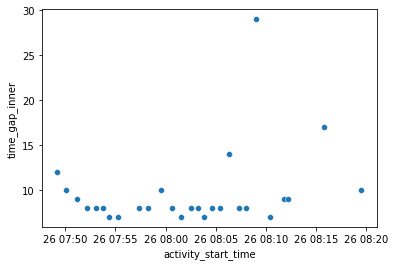

In [22]:
sns.scatterplot('activity_start_time', 'time_gap_inner', \
    data= plt_data[plt_data['user_id'] == 'SIERF54'] )